# Generative Adversarial Networks (GANs) con CelebA Dataset
## Laboratorio 6 - Data Science Sección 20
~ Samuel Chamale 21885

~ Adrian Rodriguez 21691

> *Repositorio : https://github.com/UVG-Works-Hub/celeba-gan (celeba-gan.ipynb)* 

---

## Objetivo del laboratorio

Implementar y entrenar una Red Generativa Adversarial utilizando datos de imágenes reales, con el fin de generar imágenes artificiales que imiten la distribución de los datos originales.

Se utilizará el conjunto de datos CelebA, imágenes de rostros de celebridades (debidamente anonimizadas). El objetivo es que puedan entrenar una GAN para generar rostros que parezcan realistas.

## 📦 Carga de Librerias

In [2]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers # type: ignore


##  🚧 Definición de constantes

In [2]:
# Constants
DATA_DIR = 'img_align_celeba/img_align_celeba'  # Replace with the path to your CelebA images
# Download from https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/
BATCH_SIZE = 128
IMG_HEIGHT = 64 # According to kaggle dataset
IMG_WIDTH = 64 # According to kaggle dataset
EPOCHS = 30
BUFFER_SIZE = 60000
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
SAVE_DIR = 'gan_images'
checkpoint_dir = './training_checkpoints'
MODEL_SAVE_PATH = 'gan_generator.pkl'

## 🏞️ Configuración de entorno

In [3]:
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [4]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

Dada la inmensidad del conjunto de datos decidimos configurar el uso de GPU para tensorflow y así poder obtener los resultados en un menor tiempo.

> Prompt/Conversación: https://chatgpt.com/share/66f9cb49-91d0-8012-8e27-010091c0bbd8

In [5]:
# Configure TensorFlow to use the GPU and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True to prevent TensorFlow from allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU instead.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. ⚙️ Preparación de los datos

### Preprocesamiento adecuado

In [6]:
def load_image(image_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize image to [-1, 1]
    image = (image - 127.5) / 127.5
    return image

### Carga correcta del conjunto de datos

In [7]:
image_paths = [os.path.join(DATA_DIR, fname) for fname in os.listdir(DATA_DIR)]
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 2. 🤖 Implementación de la GAN

> Prompt/Conversación: https://chatgpt.com/share/66f9cb04-9264-8012-bb76-9c82a111918f

### Diseño correcto del generador

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    # assert model.output_shape == (None, 8, 8, 256)

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 64, 64, 3)
    return model

generator = make_generator_model()

### Diseño correcto del discriminador

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                                     input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()

### Definición adecuada de funciones de pérdida y optimizadores

In [3]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images labeled as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images labeled as 0
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # Generator wants discriminator to believe fake images are real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 3. 🧪 Entrenamiento de la GAN

Dado que el proceso de entrenamiento es bastante tardado, la posibilidad de interrupciones incrementa. Es por eso que ir guardando checkpoints puede llegar a ser útil para recuperar los avances en caso de interrupciones no deseadas.

In [11]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Implementación correcta de la iteración de entrenamiento

Ahora utilizamos las funciones de perdida y optimizadores antes definidos para el proceso de discriminación. Las GAN requieren una configuración manual de los pasos intermedios durante el entrenamiento.

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Visualización adecuada de los resultados

Esta función será utilizada para visualizar los resultados a lo largo de las epochs.

In [13]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')

    plt.savefig(f'{SAVE_DIR}/image_at_epoch_{epoch:04d}.png')
    plt.show()

seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])


In [14]:
def train(dataset, epochs, patience=20):
    best_gen_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        start = time.time()
        print(f'\nEpoch {epoch + 1}/{epochs}')

        batch_time = time.time()
        # Initialize tqdm progress bar for batches
        batch_progress = tqdm(dataset, desc='Batches', unit='batch', leave=False)
        batch_count = 0

        for image_batch in batch_progress:
            train_step(image_batch)
            batch_count += 1

            # Update tqdm description with additional info if needed
            batch_progress.set_postfix({'Batch Time': f'{time.time() - batch_time:.2f}s'})
            batch_time = time.time()

        # Evaluate generator loss on a batch of noise
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator(noise, training=False)
        fake_output = discriminator(generated_images, training=False)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(tf.ones_like(fake_output), fake_output)

        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}')
        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

        # Early stopping logic
        if gen_loss < best_gen_loss:
            best_gen_loss = gen_loss
            patience_counter = 0
            # Save the best model weights
            generator.save_weights('best_generator.h5')
            discriminator.save_weights('best_discriminator.h5')
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                # Load the best model weights before stopping
                generator.load_weights('best_generator.h5')
                discriminator.load_weights('best_discriminator.h5')
                return

        # Produce images for visualization
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


Epoch 1/30


Batches:   0%|          | 0/1583 [00:00<?, ?batch/s]c:\Users\Usuario\anaconda3\envs\py310\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Generator Loss: 1.1223, Discriminator Loss: 0.7430
Time for epoch 1 is 625.24 sec


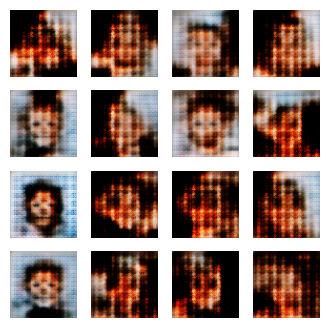


Epoch 2/30


Epoch 2, Generator Loss: 1.0430, Discriminator Loss: 0.8162
Time for epoch 2 is 422.66 sec


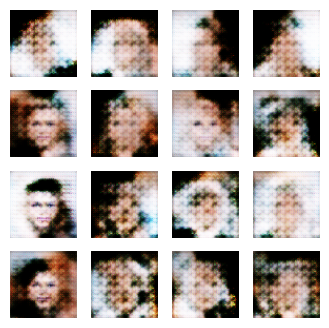


Epoch 3/30


Epoch 3, Generator Loss: 1.7655, Discriminator Loss: 0.5857
Time for epoch 3 is 415.58 sec
Patience Counter: 1/20


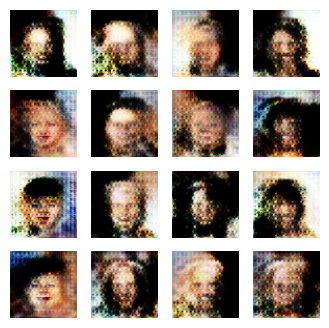


Epoch 4/30


Epoch 4, Generator Loss: 2.3038, Discriminator Loss: 0.4648
Time for epoch 4 is 411.12 sec
Patience Counter: 2/20


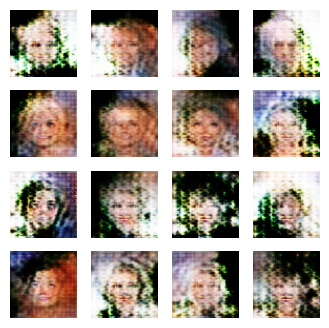


Epoch 5/30


Epoch 5, Generator Loss: 1.5796, Discriminator Loss: 0.5889
Time for epoch 5 is 418.53 sec
Patience Counter: 3/20


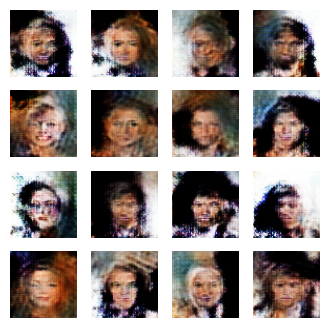


Epoch 6/30


Epoch 6, Generator Loss: 2.8544, Discriminator Loss: 0.4081
Time for epoch 6 is 430.28 sec
Patience Counter: 4/20


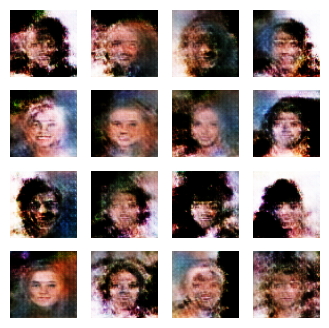


Epoch 7/30


Epoch 7, Generator Loss: 2.2364, Discriminator Loss: 0.5140
Time for epoch 7 is 434.95 sec
Patience Counter: 5/20


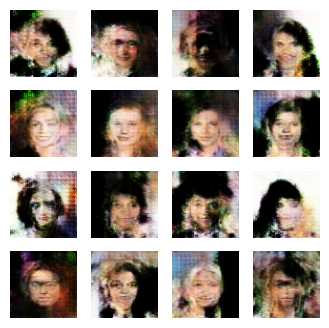


Epoch 8/30


Epoch 8, Generator Loss: 1.8937, Discriminator Loss: 0.5685
Time for epoch 8 is 743.45 sec
Patience Counter: 6/20


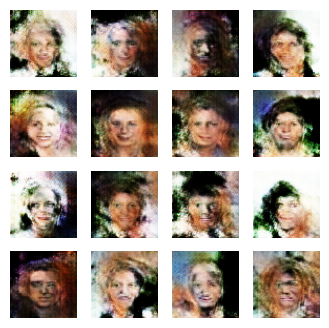


Epoch 9/30


Epoch 9, Generator Loss: 3.1353, Discriminator Loss: 0.3879
Time for epoch 9 is 541.38 sec
Patience Counter: 7/20


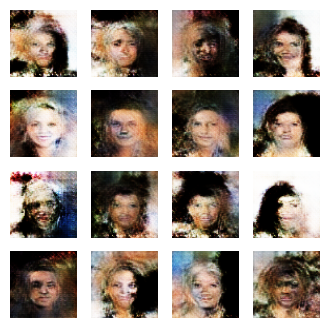


Epoch 10/30


Epoch 10, Generator Loss: 3.8279, Discriminator Loss: 0.3493
Time for epoch 10 is 483.34 sec
Patience Counter: 8/20


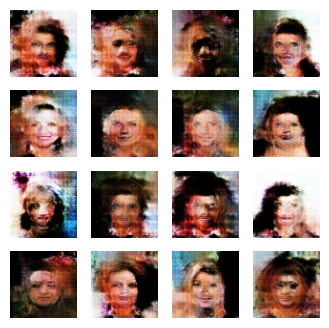


Epoch 11/30


Epoch 11, Generator Loss: 3.0872, Discriminator Loss: 0.3833
Time for epoch 11 is 496.54 sec
Patience Counter: 9/20


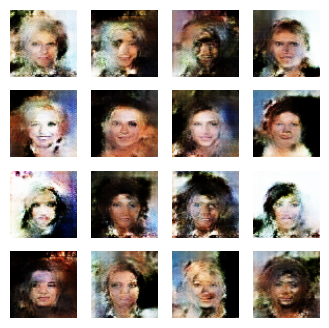


Epoch 12/30


Epoch 12, Generator Loss: 3.6061, Discriminator Loss: 0.3577
Time for epoch 12 is 463.97 sec
Patience Counter: 10/20


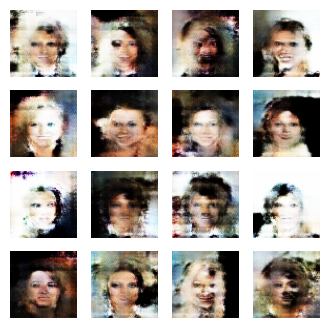


Epoch 13/30


Epoch 13, Generator Loss: 2.8343, Discriminator Loss: 0.4494
Time for epoch 13 is 422.63 sec
Patience Counter: 11/20


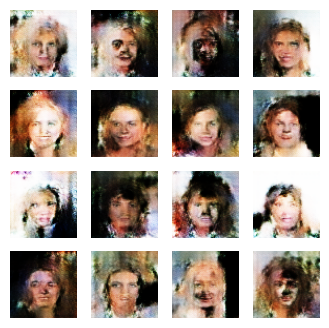


Epoch 14/30


Epoch 14, Generator Loss: 3.7316, Discriminator Loss: 0.4209
Time for epoch 14 is 418.22 sec
Patience Counter: 12/20


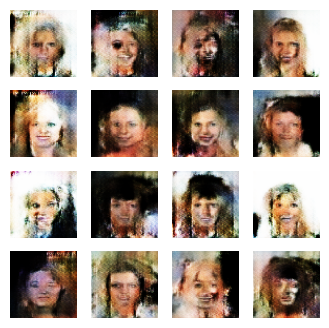


Epoch 15/30


Epoch 15, Generator Loss: 3.2286, Discriminator Loss: 0.3972
Time for epoch 15 is 452.96 sec
Patience Counter: 13/20


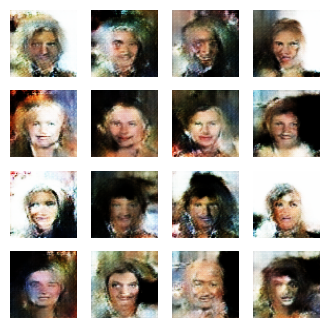


Epoch 16/30


Epoch 16, Generator Loss: 3.6777, Discriminator Loss: 0.3616
Time for epoch 16 is 417.83 sec
Patience Counter: 14/20


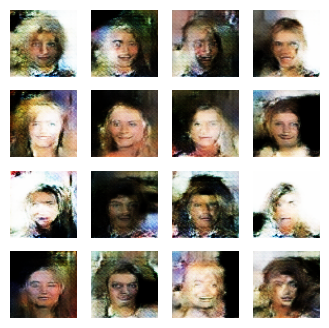


Epoch 17/30


Epoch 17, Generator Loss: 3.6865, Discriminator Loss: 0.3650
Time for epoch 17 is 528.38 sec
Patience Counter: 15/20


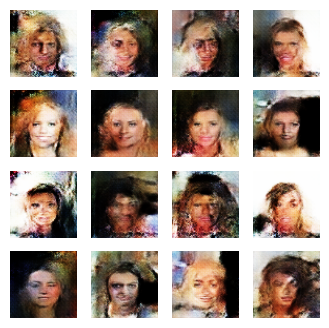


Epoch 18/30


Epoch 18, Generator Loss: 4.2135, Discriminator Loss: 0.3429
Time for epoch 18 is 772.69 sec
Patience Counter: 16/20


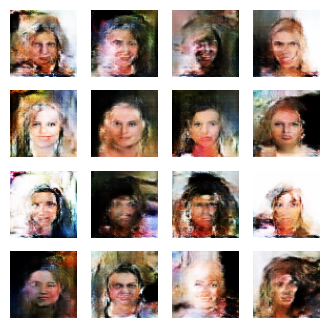


Epoch 19/30


Epoch 19, Generator Loss: 5.1754, Discriminator Loss: 0.3279
Time for epoch 19 is 450.85 sec
Patience Counter: 17/20


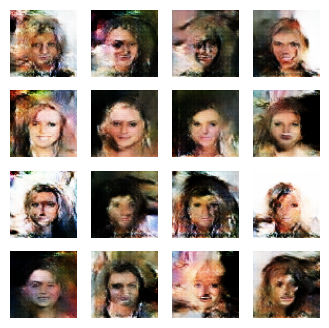


Epoch 20/30


Epoch 20, Generator Loss: 3.8750, Discriminator Loss: 0.3583
Time for epoch 20 is 418.39 sec
Patience Counter: 18/20


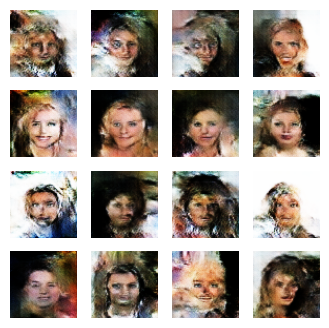


Epoch 21/30


Epoch 21, Generator Loss: 4.1870, Discriminator Loss: 0.3395
Time for epoch 21 is 416.47 sec
Patience Counter: 19/20


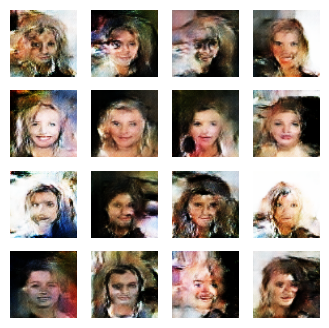


Epoch 22/30


Epoch 22, Generator Loss: 3.3256, Discriminator Loss: 0.3921
Time for epoch 22 is 418.21 sec
Patience Counter: 20/20
Early stopping triggered.


In [15]:
train(dataset, EPOCHS)

## 4. 🧠 Reflexión

1. **Conceptos teóricos desafiantes:**

    Durante la teoría, se explicó que la mejora de una red a costa de la otra puede llevar al modelo a un estado de ineficacia, incapaz de producir resultados satisfactorios. Este equilibrio es especialmente difícil de alcanzar en la práctica. Además, adaptar y ajustar las funciones de pérdida teóricas junto con los hiperparámetros fue uno de los aspectos más complejos. Aunque comprendemos, en términos generales, el funcionamiento de las diferentes capas de los modelos, realizar ajustes y comparaciones para encontrar arquitecturas óptimas resulta complicado debido al largo tiempo de entrenamiento requerido, principalmente por la cantidad de datos, que asciende a unas 200,000 imágenes.

2. **Aplicaciones potenciales de las GANs**:

    Las GANs tienen un amplio abanico de aplicaciones que van mucho más allá de la generación de imágenes triviales. Por ejemplo, pueden utilizarse en la creación de imágenes de alta calidad para el arte digital, permitiendo a los artistas explorar nuevos estilos y conceptos creativos. En el campo de la mejora de sistemas de reconocimiento facial, las GANs pueden generar variaciones de rostros bajo diferentes condiciones de iluminación, ángulos y expresiones, contribuyendo a la robustez y precisión de estos sistemas.

    Además, las GANs son especialmente útiles como modelos auxiliares para aumentar conjuntos de datos mediante la generación de imágenes sintéticas. Esto es de gran relevancia en sectores como la medicina, donde obtener datos reales puede ser complicado debido a cuestiones éticas, de privacidad o a la escasez de ejemplos de ciertas condiciones. Por ejemplo, pueden generar imágenes médicas de órganos con diversas patologías, ayudando a entrenar algoritmos de diagnóstico más precisos.

4. **Limitaciones y preocupaciones éticas**:

    Una de las principales limitaciones de las GANs es la complejidad de su entrenamiento, debido a la gran cantidad de recursos computacionales que requieren. Por ejemplo, en este laboratorio inicialmente intentamos utilizar una GPU NVIDIA RTX 2060, pero el tiempo de entrenamiento resultó ser demasiado elevado. Incluso al emplear una NVIDIA RTX 4070 SUPER, el tiempo seguía siendo considerablemente alto, con un entrenamiento completo que tomó alrededor de 2 horas y media.

    Las GANs tienen el potencial de generar imágenes realistas que pueden ser mal utilizadas para propósitos como la desinformación y la violación de la privacidad. Por lo tanto, para nosotros como desarrolladores es crucial considerar estas preocupaciones éticas al investigar y desarrollar aplicaciones basadas en GANs.

5. **Sentimientos respecto a la implementación y entrenamiento de GANs**:

    Después de la experiencia práctica, se puede reconocer que, si bien las GANs ofrecen un enfoque poderoso para la generación, su implementación y entrenamiento son bastante complejos, y requieren una comprensión amplia de los principios subyacentes.